In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import decorate, savefig

from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array

from matplotlib.colors import LinearSegmentedColormap
import math


In [15]:
def locs_where(condition):
    """Find cells where a logical array is True.
    
    condition: logical array
    
    returns: list of location tuples
    """
    return list(zip(*np.nonzero(condition)))

In [65]:

# make a custom color map
palette = sns.color_palette('muted')
colors = 'white', palette[1], palette[0], 'black'
cmap = LinearSegmentedColormap.from_list('cmap', colors)


class Schelling(Cell2D):
    """Represents a grid of Schelling agents."""
    
    options = dict(mode='same', boundary='wrap')

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)
    
    def __init__(self, n, p_r, p_b, p_school_r, p_school_b):
        """Initializes the attributes.

        n: number of rows
        p_w: threshold on the fraction of similar neighbors for red agents
        p_r: threshold on the fraction of similar neighbors for blue agents
        p_school_r: threshold on the fraction of similar schoolmates for red agents
        p_school_b: threshold on the fraction of similar schoolmates for blue agents
        """
        
        self.n = n
        
        self.p_r = p_r
        self.p_b = p_b
        self.p_school_r = p_school_r
        self.p_school_b = p_school_b
        
        # 0 is empty, 1 is red, 2 is blue, 3 is school
        choices = np.array([0, 1, 2], dtype=np.int8)
        probs = [0.1, 0.45, 0.45]
        self.array = np.random.choice(choices, (n, n), p=probs)
        
        #add the schools, equally spaced throughout the grid
        self.array[math.floor(n/4), math.floor(n/4)] = 3
        self.array[math.floor(n/4), math.floor(3*n/4)] = 3
        self.array[math.floor(3*n/4), math.floor(n/4)] = 3
        self.array[math.floor(3*n/4), math.floor(3*n/4)] = 3
        
         # create an array where the value of each cell designates the district number of the cell
        self.district = np.zeros((self.n, self.n))
        
        for i in range(self.n):
            for j in range(self.n):
                if i in range(math.floor(self.n/2)):
                    if j in range(math.floor(self.n/2)):
                        self.district[i][j] = 1
                    else:
                        self.district[i][j] = 3
                else:
                    if j in range(math.floor(self.n/2)):
                        self.district[i][j] = 2
                    else:
                        self.district[i][j] = 4
    

    def count_neighbors(self):
        """Surveys neighboring cells.
        
        returns: tuple of
            empty: True where cells are empty
            school: True where there is a school
            frac_red: fraction of red neighbors around each cell
            frac_blue: fraction of blue neighbors around each cell
            frac_same: fraction of neighbors with the same color
        """
        a = self.array
        
        empty = a==0
        red = a==1
        blue = a==2
        school = a==3

        # count red neighbors, blue neighbors, and total
        num_red = correlate2d(red, self.kernel, **self.options)
        num_blue = correlate2d(blue, self.kernel, **self.options)
        num_neighbors = num_red + num_blue

        # compute fraction of similar neighbors
        frac_red = num_red / num_neighbors
        frac_blue = num_blue / num_neighbors
        
        # no neighbors is considered the same as no similar neighbors 
        # (this is an arbitrary choice for a rare event)
        frac_red[num_neighbors == 0] = 0
        frac_blue[num_neighbors == 0] = 0
        
        # for each cell, compute the fraction of neighbors with the same color
        frac_same = np.where(red, frac_red, frac_blue)

        # for empty cells, frac_same is NaN
        frac_same[empty] = np.nan
        frac_same[school] = np.nan
        
        return empty, school, frac_red, frac_blue, frac_same
    
    
    def count_district(self):
        """Surveys cells within the same school district.
        returns: tuple of
            empty: True where cells are empty
            school: True where there is a school
            frac_red: fraction of red agents in the school district as the cell
            frac_blue: fraction of blue agents in the school district as the cell
            frac_same: fraction of agents with the same color in the school district as the cell
        """
        
        a = self.array
        
        empty = a==0
        red = a==1
        blue = a==2
        school = a==3
        
        frac_red = np.zeros((self.n, self.n))
        frac_blue = np.zeros((self.n, self.n))
        
        # iterate over all 4 districts
        for dis_number in range(1,5):
            # get array of cells that are red in this district
            red_district = np.logical_and(red, self.district == dis_number)
            
            #count number of red agents in this district
            num_red = np.count_nonzero(red_district)
            
            # put number of red neighbors in this district in each cell
            num_red_array = np.where(self.district == dis_number, num_red, 0)
            
            # get array of cells that are blue in this district
            blue_district = np.logical_and(blue, self.district == dis_number)
            
            #count number of blue agents in this district
            num_blue = np.count_nonzero(blue_district)
            
            # put number of blue neighbors in this district in each cell
            num_blue_array = np.where(self.district == dis_number, num_blue, 0)
            
            num_total = num_red + num_blue
            
            frac_red += num_red_array/num_total
            frac_blue += num_blue_array/num_total
            
            #if there are no agents in the district, set frac to 0
            frac_red[num_total == 0] = 0
            frac_blue[num_total == 0] = 0
        
        frac_same = np.where(red, frac_red, frac_blue)

        # for empty cells, frac_same is NaN
        frac_same[empty] = np.nan
        frac_same[school] = np.nan
        
        return empty, school, frac_red, frac_blue, frac_same

    def segregation(self):
        """Computes the average fraction of similar neighbors.
        
        returns: fraction of similar neighbors, averaged over cells
        """
        _, _, _, _, frac_same = self.count_neighbors()
        return np.nanmean(frac_same)
    
    def step(self):
        """Executes one time step.
                
        returns: fraction of similar neighbors, averaged over cells
        """
    
        a = self.array
        
        red = a==1
        blue = a==2
        
        empty, _, _, _, frac_same_nbhd = self.count_neighbors()
        _, _, _, _, frac_same_district = self.count_district()
        
        # find the unhappy cells (ignore NaN in frac_same)
        with np.errstate(invalid='ignore'):
            #find cells unhappy with their neighborhood
            unhappy_nbhd = np.logical_or(np.logical_and(frac_same_nbhd < self.p_r, red), np.logical_and(frac_same_nbhd < self.p_b, blue))
            
            #find cells unhappy with their school district
            unhappy_district = np.logical_or(np.logical_and(frac_same_district < self.p_school_r, red), np.logical_and(frac_same_district < self.p_school_b, blue))
            
        #identify locations of cells that should move districts
        move_district = np.logical_and(unhappy_nbhd, unhappy_district)
        
        #identify locations of cells that should move neighborhoods (stay in district)
        move_nbhd = np.logical_and(unhappy_nbhd, np.logical_not(unhappy_district))
        
        move_nbhd_locs = locs_where(move_nbhd)
        move_district_locs = locs_where(move_district)
        
        # find the empty cells
        empty_locs = locs_where(empty)
        
        #get the district of origin of each agent that wants to move districts
        orig_district = self.district[move_district_locs]
        
        # shuffle the unhappy cells
        if len(move_district_locs):
            np.random.shuffle(move_nbhd_locs)
        
        for index in range(len(move_district_locs)):
            source = move_district_locs[index]
            dis_num = orig_district[index]
            
            #TODO: for each cell in the orig_district array, generate a random district for the agent to go to (that is not the district they came from)
            
            # for each unhappy district cell, choose a random destination (but need to make sure the destination is not in the same district)
            num_empty = np.sum(empty)
            
            i = np.random.randint(num_empty)
            dest = empty_locs[i]
            
            # move
            a[dest] = a[source]
            a[source] = 0
            empty_locs[i] = source
        
        # check that the number of empty cells is unchanged
        num_empty2 = np.sum(a==0)
        assert num_empty == num_empty2
        
        # return the average fraction of similar neighbors
        return np.nanmean(frac_same)
       
    def draw(self):
        """Draws the cells."""
        return draw_array(self.array, cmap=cmap, vmax=3)

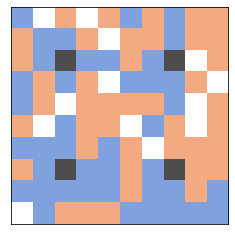

In [66]:
grid = Schelling(n=10, p_r = 0.4, p_b = 0.7, p_school_r = 0.4, p_school_b = 0.7)

a = grid.count_district()
grid.draw()

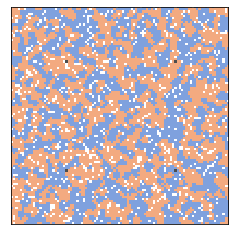

In [47]:
grid = Schelling(n=100, p=0.3)
grid.animate(frames=30, interval=0.1)

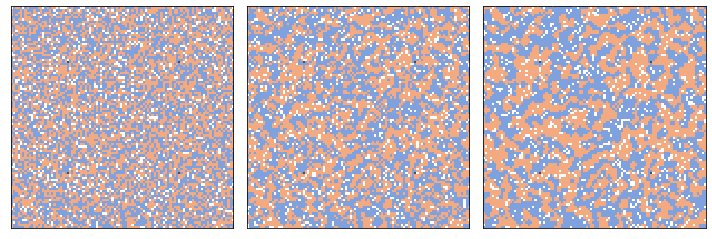

In [48]:
from utils import three_frame

grid = Schelling(n=100, p=0.3)
three_frame(grid, [0, 2, 8])


In [16]:
a = np.array([1, 2, 3, 4, 1])

In [17]:
b = np.array(['a', 'b', 'a', 'b', 'a'])

In [21]:
c = (a == 1)
d = b == 'a'

In [35]:
final = np.logical_and(c ,d)
final

array([ True, False, False, False,  True])

In [36]:
a = [4 if cell == True else 0 for cell in final]

In [37]:
a

[4, 0, 0, 0, 4]

In [3]:
k = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)

In [30]:
from scipy.signal import correlate2d
r = np.array([[0, 1, 0], [1, 1, 0], [1, 1, 0]], dtype=np.int8)
b = np.array([[0, 0, 1], [0, 0, 1], [0, 0, 1]], dtype=np.int8)
options = dict(mode='same', boundary='wrap')
num_r = correlate2d(r, k, **options)
num_b = correlate2d(b, k, **options)

num_total = num_r + num_b

frac_r = num_r/num_total
frac_b = num_b/num_total

In [34]:
num_r

array([[5, 4, 5],
       [4, 4, 5],
       [4, 4, 5]], dtype=int8)

In [32]:
frac_r

array([[0.625     , 0.57142857, 0.71428571],
       [0.57142857, 0.57142857, 0.71428571],
       [0.57142857, 0.57142857, 0.71428571]])

In [33]:
num_total

array([[8, 7, 7],
       [7, 7, 7],
       [7, 7, 7]], dtype=int8)

In [87]:
num_total[(0,0),(0,1)]

array([8, 7], dtype=int8)